In [50]:
import math
import numpy as np
from IPython.display import clear_output
import pdb
import time
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions import MultivariateNormal
use_cuda = torch.cuda.is_available()
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import gc
import importlib
import Utils
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory
from Utils import SaveTrajectory as st
import ODEModel
importlib.reload(ODEModel)
from ODEModel import ODEfunc, Siren
from ODEModel import FfjordModel
import LearnTraj
importlib.reload(LearnTraj);
from LearnTraj import learn_trajectory
import os;

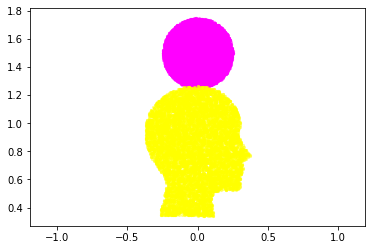

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
caterpillar,im = ImageDataset.import_img('caterpillar.png'); caterpillar=1-caterpillar; caterpillar/=caterpillar.max();
butterfly,im = ImageDataset.import_img('butterfly.jpg'); butterfly=255-butterfly; butterfly/=butterfly.max();
circle,im = ImageDataset.import_img('circle.jpeg'); circle=255-circle; circle/=circle.max();
baldhead,im = ImageDataset.import_img('baldhead.jpeg'); baldhead=255-baldhead; baldhead/=baldhead.max();
square,im = ImageDataset.import_img('square.png', rgb_weights=[0.2989, 0.5870, 0.1140,0]); square=1-square; square/=square.max();
cat1,im = ImageDataset.import_img('cat1.png', rgb_weights = [0.2989, 0.5870, 0.1140, 1]); cat1/=cat1.max();
dset1 = ImageDataset(img=caterpillar*1,thresh=.8); 
dset2 = ImageDataset(img=butterfly*1,thresh=.8)
dset3 = ImageDataset(img=circle*1,thresh=.8)
dset4 = ImageDataset(img=square*1,thresh=.8)
dset5 = ImageDataset(img=cat1*1,thresh=.8)
dset6 = ImageDataset(img=baldhead*1,thresh=.8)

n = 10000; 
dat1 = dset1.sample(n); 
dat2 = dset2.sample(n); 
dat3 = dset3.sample(n)*.7;
dat4 = dset4.sample(n);
dat5 = dset5.sample(n);
dat6 = dset6.sample(n);
dat1*=-1; dat1[:,1]-=.1;
dat2*=-1; dat2[:,1]+=.5; 
dat3[:,1]+=1.5;
dat5[:,1]*=-1;
dat6[:,1]*=-1; dat6[:,1]+=.8;

# plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='green') # butterfly
# plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='red') # caterpillar
plt.scatter(dat3.detach().numpy()[:,0],dat3.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='magenta') # circle
# plt.scatter(dat4.detach().numpy()[:,0],dat4.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='orange')
# plt.scatter(dat5.detach().numpy()[:,0],dat5.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='yellow')
plt.scatter(dat6.detach().numpy()[:,0],dat6.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='yellow') # face
plt.axis('equal')
plt.show() 

training with sinkhorn_large_reg
lr 1e-06
batch 0 loss tensor(1., grad_fn=<AddBackward0>)


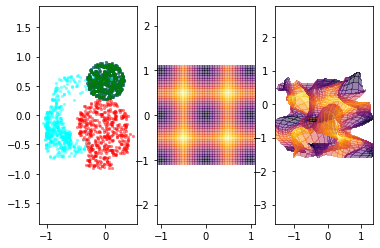

time elapsed 0.6338577270507812 total time 0.6338577270507812
batch number 0 out of 3000
savetime 0.0
n_subsample 915
lr 1e-06
batch 150 loss tensor(0.0104, grad_fn=<AddBackward0>)


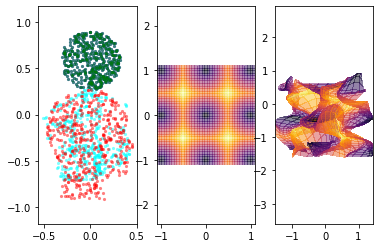

time elapsed 60.35093855857849 total time 60.98479628562927
batch number 150 out of 3000
savetime 1.6514856815338135
n_subsample 1674
lr 1e-06
batch 300 loss tensor(0.0074, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

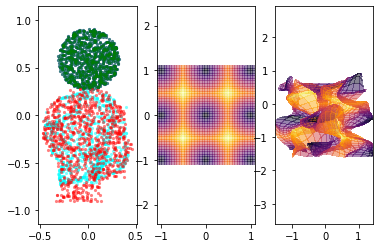

time elapsed 161.147141456604 total time 223.7834234237671
batch number 300 out of 3000
savetime 1.5886104106903076
n_subsample 3000
lr 1e-06
batch 450 loss tensor(0.0058, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

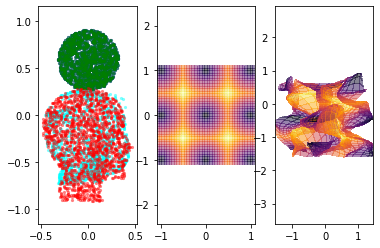

time elapsed 434.7060613632202 total time 660.0790920257568
batch number 450 out of 3000
savetime 1.6430742740631104
lr 1e-06
batch 600 loss tensor(0.0045, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

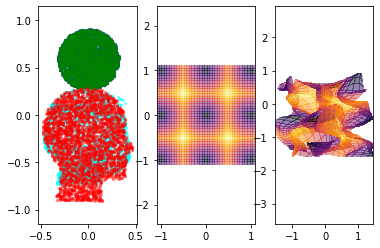

time elapsed 1233.5383274555206 total time 1895.2604937553406
batch number 600 out of 3000
savetime 1.9347822666168213
lr 1e-06
batch 750 loss tensor(0.0039, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

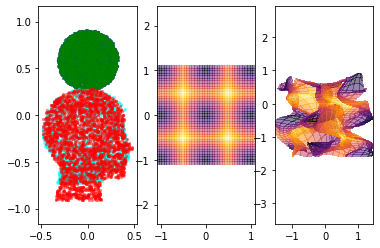

time elapsed 1219.1951920986176 total time 3116.3914651870728
batch number 750 out of 3000
savetime 1.6886723041534424
lr 1e-06
batch 900 loss tensor(0.0039, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

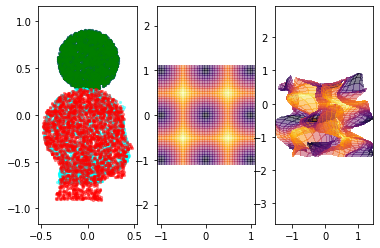

time elapsed 1214.6077048778534 total time 4332.68883895874
batch number 900 out of 3000
savetime 1.7293236255645752
lr 1e-06
batch 1050 loss tensor(0.0036, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

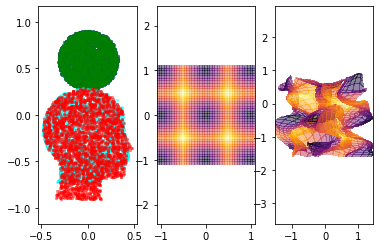

time elapsed 1207.6824810504913 total time 5542.101640462875
batch number 1050 out of 3000
savetime 2.001695156097412
lr 1e-06
batch 1200 loss tensor(0.0037, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

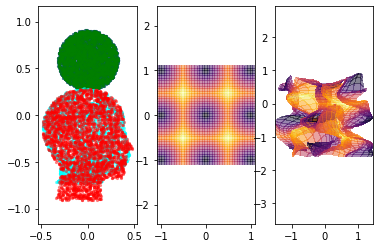

time elapsed 1185.7183265686035 total time 6729.822629928589
batch number 1200 out of 3000
savetime 1.662872314453125
lr 5e-07
batch 1350 loss tensor(0.0038, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

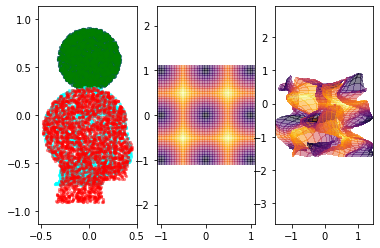

time elapsed 1177.9416506290436 total time 7909.427152872086
batch number 1350 out of 3000
savetime 1.6768949031829834
lr 5e-07
batch 1500 loss tensor(0.0034, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

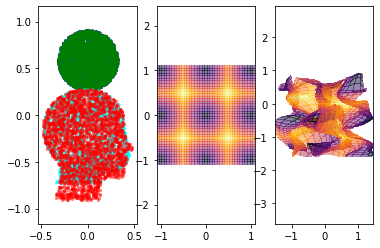

time elapsed 1159.8178577423096 total time 9070.921905517578
batch number 1500 out of 3000
savetime 1.8425145149230957
lr 5e-07
batch 1650 loss tensor(0.0035, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

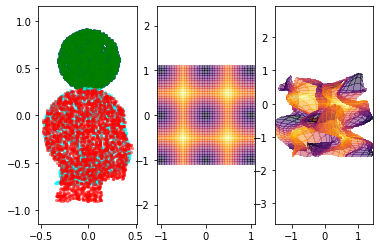

time elapsed 1160.3939983844757 total time 10233.158418416977
batch number 1650 out of 3000
savetime 1.6416702270507812
lr 2.5e-07
batch 1800 loss tensor(0.0037, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

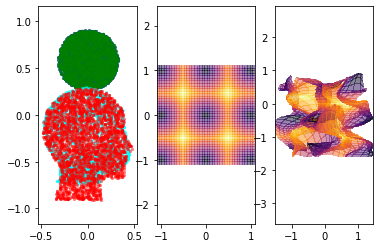

time elapsed 1162.8790884017944 total time 11397.679177045822
batch number 1800 out of 3000
savetime 1.7064480781555176
lr 2.5e-07
batch 1950 loss tensor(0.0048, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

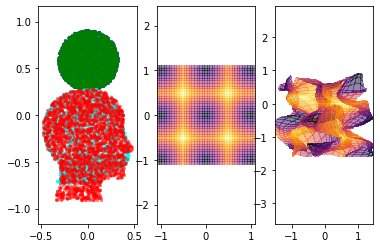

time elapsed 1155.4987063407898 total time 12554.884331464767
batch number 1950 out of 3000
savetime 1.6214027404785156
lr 1.25e-07
batch 2100 loss tensor(0.0037, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

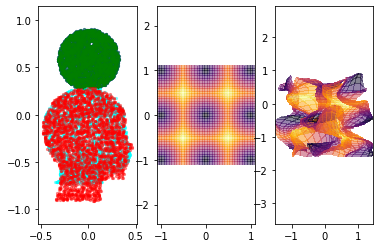

time elapsed 1155.4624738693237 total time 13711.96820807457
batch number 2100 out of 3000
savetime 1.6673469543457031
lr 1.25e-07
batch 2250 loss tensor(0.0035, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

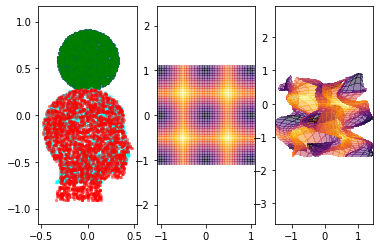

time elapsed 1163.511486530304 total time 14877.14704155922
batch number 2250 out of 3000
savetime 1.6194946765899658
lr 1.25e-07
batch 2400 loss tensor(0.0030, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

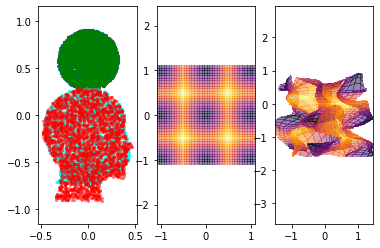

time elapsed 1152.3456225395203 total time 16031.11215877533
batch number 2400 out of 3000
savetime 1.6895952224731445
lr 1.25e-07
batch 2550 loss tensor(0.0034, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

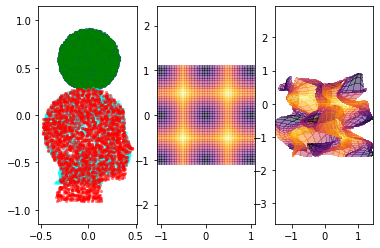

time elapsed 1149.898136138916 total time 17182.69989013672
batch number 2550 out of 3000
savetime 1.6561710834503174
lr 1e-07
batch 2700 loss tensor(0.0032, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

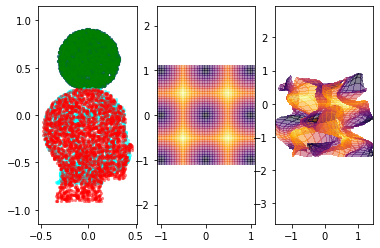

time elapsed 1171.3393414020538 total time 18355.695402622223
batch number 2700 out of 3000
savetime 1.7413840293884277
lr 1e-07
batch 2850 loss tensor(0.0042, grad_fn=<AddBackward0>)


<Figure size 432x288 with 0 Axes>

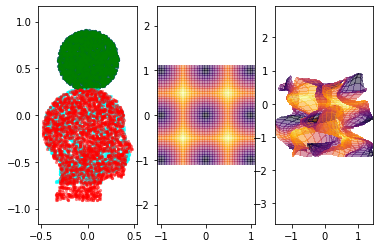

time elapsed 1163.1430308818817 total time 19520.579817533493
batch number 2850 out of 3000
savetime 1.8779025077819824


<Figure size 432x288 with 0 Axes>

In [52]:
z_target = ImageDataset.normalize_samples(torch.stack((dat3, dat6)).to(device));
# usesiren = False; first_omega_0=20; sigmac = 10;
usesiren = True; first_omega_0=20; sigmac = 10;
model = Siren(first_omega_0=first_omega_0, usesiren = usesiren, sigmac = sigmac).to(device); 
bmodel = Siren(first_omega_0=first_omega_0, usesiren = usesiren, sigmac = sigmac).to(device); 
# model.load_state('models/seq_state420_time_31.615391731262207.tar');
# model.load_state('models/state310_time_22.49951934814453.tar');
# model.load_state('models/state_start.tar');
# for my_loss in ['sinkhorn_small_reg']:
# my_loss = 'sinkhorn_small_reg';
my_loss = 'sinkhorn_large_reg';
# %prun 
model, losses, separate_losses, lrs, n_subs = learn_trajectory(z_target, my_loss=my_loss,n_iters = 3000,n_subsample=500, model=model, bmodel=bmodel, save=True)

In [53]:
# st.gpu_usage()
# z_target.shape
# z_target = ImageDataset.normalize_samples(torch.stack((dat2, dat1)).to(device));

# torch.cuda.empty_cache()
# z_target = ImageDataset.normalize_samples(torch.stack((dat2, dat1)).to(device));
# model = FfjordModel().to(device); model.load_state('models/state_start.tar'); # print(next(model.parameters()).is_cuda)
# my_loss = 'sinkhorn_large_reg';
myln = my_loss+'_0';
st.save_trajectory(model,z_target[:,1:4000,:],myln, savedir='imgs', nsteps=20, memory=0.01, n=500,dpiv=400)
st.gpu_usage()
st.trajectory_to_video(myln, savedir='imgs', mp4_fn='transform.mp4')

# integration_times = torch.linspace(0,z_target.shape[0]-1,2).to(device);
# model(z_target[1,:,:], integration_times)


Allocated: 0.0 GB  Reserved: 0.0 GB


<Figure size 432x288 with 0 Axes>

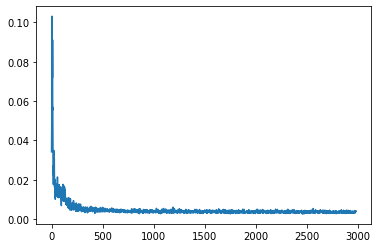

In [64]:
start=15;end=20000;
plt.plot(losses[start:end]); 
# plt.plot(separate_losses[0,start:end],'g'); 
# plt.plot(separate_losses[1,start:end],'r'); 
# plt.plot(separate_losses[2,start:end]); 
# plt.plot(separate_losses[3,start:end]*.01,'r'); 
# plt.plot(separate_losses[4,start:end]*10,'b'); 
# plt.plot(separate_losses[5,start:end]); 
# plt.plot(separate_losses[6,start:end]);
plt.savefig(os.path.join('./', f"viz_loss.jpg"),dpi=400); 

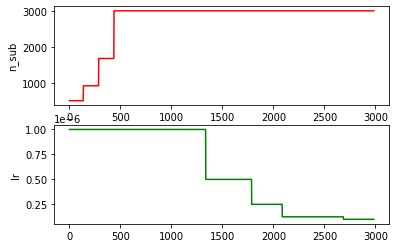

In [65]:
(fig,(ax1,ax2))=plt.subplots(2,1)
ax1.plot(n_subs[start:end],'r'); ax1.set_ylabel('n_sub')
ax2.plot(lrs[start:end],'g'); ax2.set_ylabel('lr') 
plt.savefig(os.path.join('./', f"viz_stat.jpg"),dpi=400); 

In [ ]:
torch.cuda.empty_cache() 
st.gpu_usage()

In [ ]:
# test what weights are given to what frequencies in the first layer
for param in model.parameters():
    print(type(param.data), param.size())
    pdat = param.data;
    break;    
pmags = torch.norm(param.data,p=2,dim=0);
freqs = model.time_deriv_func.imap.B;
nf = freqs.shape[0];
nd = (pmags.shape[0]-2*nf)

fmags = torch.norm(freqs,p=2,dim=1);
xyfreqs = torch.cat([fmags, fmags],dim=0);
print(xyfreqs.size())

plt.plot(xyfreqs.cpu().numpy(), pmags[0:(nf*2)].cpu().numpy(),'.')
plt.plot(np.zeros(nd), pmags[(nf*2):].cpu().numpy(),'.')
plt.savefig(os.path.join('./', f"viz_freqs.jpg"),dpi=400); 
# # freqs
# # fmags

In [ ]:
## visualize ending sinkhorn costs as gradient on point clouds
# z_target = ImageDataset.normalize_samples(torch.stack((dat1,dat4)).to(device));
T = z_target.shape[0];

z_t = model(z_target[0,:,:], integration_times = torch.linspace(0,T-1,T).to(device),reverse=False);
z_t_b = model(z_target[T-1,:,:], integration_times = torch.linspace(0,T-1,T).to(device),reverse=True);
forward = z_t[T-1,:,:].cpu().detach().numpy();
backward = z_t_b[T-1,:,:].cpu().detach().numpy();

my_loss_f = SamplesLoss("sinkhorn", p=2, blur=0.01);
loss_f = my_loss_f(z_target[T-1,:,:], z_t[T-1,:,:])
loss_b = my_loss_f(z_target[0,:,:], z_t_b[T-1,:,:])

graddirs_f = torch.autograd.grad(loss_f, z_t)[0][T-1,:,:]
graddirs_b = torch.autograd.grad(loss_b, z_t_b)[0][T-1,:,:]

pos_f = z_t.cpu().detach().numpy()
pos_b = z_t_b.cpu().detach().numpy()
dirs_f = graddirs_f.cpu().detach().numpy()
dirs_b = graddirs_b.cpu().detach().numpy()

import os
plt.axis('equal')
plt.scatter(pos_b[0,:,0], pos_b[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
plt.scatter(forward[:,0], forward[:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
plt.quiver(pos_f[T-1,:,0], pos_f[T-1,:,1], dirs_f[:,0], dirs_f[:,1],scale=.0001)
plt.savefig(os.path.join('./', f"viz_backward.jpg"),dpi=400); plt.clf()

plt.axis('equal')
plt.scatter(pos_f[0,:,0], pos_f[0,:,1], s=10, alpha=.5, linewidths=0, c='green', edgecolors='black')
plt.scatter(backward[:,0], backward[:,1], s=10, alpha=.5, linewidths=0, c='red', edgecolors='black')
plt.quiver(pos_b[T-1,:,0], pos_b[T-1,:,1], dirs_b[:,0], dirs_b[:,1],scale=.0001)
plt.savefig(os.path.join('./', f"viz_forward.jpg"),dpi=400); 


In [ ]:
#trying other shapes

square = np.zeros([20,20])
square[6:14,:8] = 1

two_square = np.zeros([20,20])
two_square[:5,14:] = 1
two_square[15:,14:] = 1


annulus = import_img('annulus.png')
circle = 255-import_img('circle.jpeg')

dset = ImageDataset(img=square)
dset1 = ImageDataset(img=two_square)

n = 500
dat = dset.sample(n)
dat1 = dset1.sample(n)
plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='red')
plt.show() 

In [ ]:
# make half moon dataset
import sklearn.datasets

moons, labels = sklearn.datasets.make_moons(n,noise=.1) #generates two half moons
mask = (labels == 0)
one_moon = moons[mask,:] # only keep one moon

def rot_mat(theta0):
    #computes rotation matrix of angle theta
    return np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])

theta0 = np.pi/2
theta1 = np.pi

rot0 = rot_mat(theta0)
rot1 = rot_mat(theta1)

# apply rotation to the moon
one_moon_rot0 = np.dot(one_moon,rot0)
one_moon_rot1 = np.dot(one_moon,rot1)

In [ ]:
#visualize rotated moons

plt.scatter(one_moon[:,0],one_moon[:,1], color='blue')
plt.scatter(one_moon_rot0[:,0],one_moon_rot0[:,1], color='orange')
plt.scatter(one_moon_rot1[:,0],one_moon_rot1[:,1], color='green')

In [ ]:
# with three timesteps

dat = torch.tensor(one_moon,dtype=torch.float)
dat0 = torch.tensor(one_moon_rot0,dtype=torch.float)
dat1 = torch.tensor(one_moon_rot1,dtype=torch.float)

dat_tuple = (dat,dat0,dat1)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
# with two timesteps


dat_tuple = (dat,dat0)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
losses